## Pré-processamento e explocação do corpus FakeWhatsApp.br

In [1]:
!pip install emoji
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=6443cf485807784897f8a6047c09d35db507476a27dedfe5b1cb3eeeb67b0995
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
# Importação de bibliotecas utilizadas no pré-processamento
import os
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
%matplotlib inline
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)

### Baixar os dados do [FakeWhatsApp.br](https://github.com/cabrau/FakeWhatsApp.Br)

*Atenção:* Para rodar localmente, é preciso salvar o corpus no diretorio do projeto.

In [3]:
!git clone https://github.com/cabrau/FakeWhatsApp.Br

Cloning into 'FakeWhatsApp.Br'...
remote: Enumerating objects: 1053, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 1053 (delta 83), reused 189 (delta 83), pack-reused 864
Receiving objects: 100% (1053/1053), 413.70 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (329/329), done.
Checking out files: 100% (235/235), done.


In [5]:
DADOS_CAMINHO = "/content/FakeWhatsApp.Br/data/2018/fakeWhatsApp.BR_2018.csv"
fakewhats_df = pd.read_csv(DADOS_CAMINHO, sep = ',', usecols=['text', 'misinformation'])
fakewhats_df.rename(columns={'text': 'texto', 'misinformation': 'classe'}, inplace=True)
dados = fakewhats_df[fakewhats_df['classe'] > -1].copy()
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21289 entries, 15 to 282556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   21289 non-null  object
 1   classe  21289 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 499.0+ KB


### Exploração e limpeza de dados

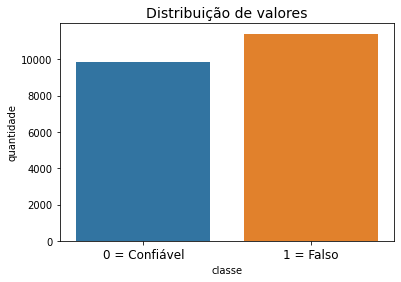

,texto
classe,
0,9877
1,11412


In [6]:
def exibir_distribuicao_valores(dados):
    ax = sns.countplot(x="classe", data=dados)
    ax.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
    ax.set_title("Distribuição de valores", fontsize=14)
    ax.set_ylabel('quantidade')
    plt.show()    
    display(dados[['texto','classe']].groupby(['classe']).count())    
    
exibir_distribuicao_valores(dados)

In [7]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', texto)
    texto = re.sub('(\n|\r)', '', texto)
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Limpa restante do texto para manter apenas conteúdo útil
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = texto.replace('...', '').replace("..", ".").replace(". .", ".")
    # Remove multiplos caracteres em branco
    texto = re.sub(r'\s+',' ', texto)
    return texto.strip()

dados["texto_limpo"] = dados.texto.apply(limpar_textos)

In [11]:
dados.sample(n=5)

,texto,classe,texto_limpo
162854,https://youtu.be/QvSF3FrYs6g\n\nFalta 35 dias para a eleição.\n\nNo Tocantins ao senado temos na chapa de Bolsonaro o agente da polícia federal: Farlei\n\nFarlei tem recebido apoio dos apoiadores ...,0,Falta 35 dias para a eleição. No Tocantins ao senado temos na chapa de Bolsonaro o agente da polícia federal: Farlei Farlei tem recebido apoio dos apoiadores de Bolsonaro dos grupos: 1. Amor pelo ...
56132,"ATENÇÃO: PAULO GUEDES \nAmanhã 17/set/18, Paulo Guedes Ministro da Fazenda de Bolsonaro, no Roda Viva da TV Cultura, às 22:10h, após o jornal da Cultura. Favor divulgarem. Obrigada",0,"ATENÇÃO: PAULO GUEDES Amanhã 17set18, Paulo Guedes Ministro da Fazenda de Bolsonaro, no Roda Viva da TV Cultura, s 22:10h, após o jornal da Cultura. Favor divulgarem. Obrigada"
112371,"É um empresário respeitado e que Ganhou o Top Ser Humano da Abrh este ano, Luís Binoto. Mensagem correta e sem ideologia alguma.",0,"É um empresário respeitado e que Ganhou o Top Ser Humano da Abrh este ano, Luís Binoto. Mensagem correta e sem ideologia alguma."
202001,"A Globo fez contra LEONEL BRIZOLA nos anos 90, o mesmo que está fazendo hoje contra Bolsonaro. Veja o que Brizola conseguiu na justiça.👇🏽",1,"A Globo fez contra LEONEL BRIZOLA nos anos 90, o mesmo que está fazendo hoje contra Bolsonaro. Veja o que Brizola conseguiu na justiça."
219386,"Vamos dar ""dislike"" nos vídeos dos artistas ""rouanet's"" ""EleNão""\nClica no link, vai aparecer o vídeo e vc clica na mãozinha 👎🏼. A diferença do 👎🏼 para o 👍🏼 é gigantesca.\n\nAnitta\nhttps://youtu...",1,"Vamos dar ""dislike"" nos vídeos dos artistas ""rouanets"" ""EleNão"" Clica no link, vai aparecer o vídeo e vc clica na mãozinha . A diferença do para o é gigantesca. Anitta Daniella Mercury Letícia Sab..."


In [ ]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 22.2/22.2 MB 5.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


### Pré-processamento com Spacy
Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)   
Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 


In [ ]:
import pt_core_news_sm
nlp = pt_core_news_sm.load()
# Remover stopwords e lematizar as setenças, a pontuação foi mantida token.is_punct (depois de testes de treino)
dados["texto_processado"] = dados.texto_limpo.apply(lambda texto: " ".join([token.lemma_ for token in nlp(texto) if not token.is_stop]))

In [ ]:
# Confere resultados visualmente
dados.sample(n=3)

,texto,classe,texto_limpo,texto_processado
188394,"A gang petista acabou de cometer suicídio político! Esse vídeo seria a única coisa que jamais deveriam ter feito, e com certeza o presidiário chefe da gang não foi comunicado. Assistam e passe pra todo mundo:",1,"A gang petista acabou de cometer suicídio político! Esse vídeo seria a única coisa que jamais deveriam ter feito, e com certeza o presidiário chefe da gang não foi comunicado. Assistam e passe pra todo mundo:","gang petista acabar cometer suicídio político ! vídeo único jamais dever fazer , presidiário chefe gang comunicar . Assistam passar pra mundo :"
232032,📱 *Melhores Preços em Peças e Serviços para Celulares* 📱\n\n✅ *Interessados Chamar no PV*,0,Melhores Preços em Peças e Serviços para Celulares* Interessados Chamar no PV*,Melhores Preços Peças Serviços Celulares * Interessados Chamar PV *
29862,"Manuela saindo da missa, depois que o padre jogou água benta",1,"Manuela saindo da missa, depois que o padre jogou água benta","Manuela sair missar , padrar jogar água bento"


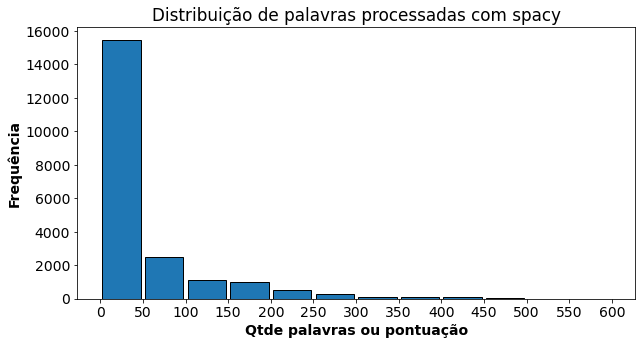

In [ ]:
# A distribuição mudou e temo ter problemas de viés com a frases mais longas
distribiucao_palavras(dados, "texto_processado", "Distribuição de palavras processadas com spacy")

In [ ]:
dados["qtde_texto_limpo"] = dados.texto_limpo.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados["qtde_texto_processado"] = dados.texto_processado.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))

,texto,classe,texto_limpo,texto_processado,qtde_texto_limpo,qtde_texto_processado
63254,Www.tse.ju.br : Faço campanha de graça para Jair Messias Bolsonaro - Faço campanha de graça para Jair Messias Bolsonaro - https://secure.avaaz.org/po/petition/Wwwtsejubr_Faco_campanha_de_graca_para_Jair_Messias_Bolsonaro/?zIetWmb,1,Www.tse.ju.br Faço campanha de graça para Jair Messias Bolsonaro,Www.tse.ju.br campanha graça Jair Messias Bolsonaro,15,12
130228,Vanda Monteiro reúne multidão no lançamento da sua campanha para deputada estadual - https://www.jmnoticia.com.br/2018/08/25/vanda-monteiro-reune-multidao-no-lancamento-da-sua-campanha-para-deputada-estadual/\n\n*#TOCOMVANDA17123💞*\n👆👆👆👆👆 CONFIRA,0,Vanda Monteiro reúne multidão no lançamento da sua campanha para deputada estadual TOCOMVANDA17123* CONFIRA,Vanda Monteiro reunir multidão lançamento campanha deputar estadual TOCOMVANDA17123 * CONFIRA,14,10
181506,"🚨🚨🚨🚨🚨🚨🚨🚨\nReunião as 19hs na praça Cel Raimundo Moreira Lima, em frente o Paraíba.\nContamos com a presença de todos!\n🚨🚨🚨🚨🚨🚨🚨🚨",0,"Reunião as 19hs na praça Cel Raimundo Moreira Lima, em frente o Paraíba. Contamos com a presença de todos!","Reunião 19hs praça Cel Raimundo Moreira Lima , frente Paraíba . Contamos presença !",22,14


In [ ]:
dados.sample(n=3)

,texto,classe,texto_limpo,texto_processado,qtde_texto_limpo,qtde_texto_processado
149446,*Pesquisa ibope mostra Fernando Haddad 49% Jair Bolsonaro com 51% e que Haddad pode ganhar de virada*\n\n https://g1.globo.com https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcTu8G-W0iEFB7QbWgrqjsTtmofCMcY9Gp1MrRrI5XQ3LDeqGmG-cmSGKTqF,1,*Pesquisa ibope mostra Fernando Haddad 49% Jair Bolsonaro com 51% e que Haddad pode ganhar de virada* ANd9GcTu8GcmSGKTqF,* Pesquisa ibope mostrar Fernando Haddad 49 % Jair Bolsonaro 51 % Haddad ganhar virar * ANd9GcTu8GcmSGKTqF,18,13
35140,"Declaração do Juiz Federal Sérgio Mouro:\nO povo brasileiro tem nas mãos o poder de fazer justiça contra os políticos corruptos que tanto tem defraudado nossa nação, impondo ao povo brasileiro todo tipo de sofrimento e miséria.\nTodo Congressista Nacional que não for reeleito, perde o foro privilegiado e, consequentemente será preso pela Polícia Federal, exatamente como ocorreu com o Deputado Federal Eduardo Cunha.\nPortanto povo brasileiro, você tem pela primeira vez na história dessa naçã...",1,"Declaração do Juiz Federal Sérgio Mouro: O povo brasileiro tem nas mãos o poder de fazer justiça contra os políticos corruptos que tanto tem defraudado nossa nação, impondo ao povo brasileiro todo tipo de sofrimento e miséria. Todo Congressista Nacional que não for reeleito, perde o foro privilegiado e, consequentemente será preso pela Polícia Federal, exatamente como ocorreu com o Deputado Federal Eduardo Cunha. Portanto povo brasileiro, você tem pela primeira vez na história dessa nação, a...","Declaração Juiz Federal Sérgio Mouro : brasileiro mão justiçar político corrupto defraudar nação , impor brasileiro sofrimento miséria . Congressista Nacional reeleito , perder foro privilegiar , consequentemente ser presar Polícia Federal , exatamente ocorrer Deputado Federal Eduardo Cunha . brasileiro , história nação , oportunidade colocar CADEIA intocável bandido Colarinhos branco . anular votar , votar mandatar , reeleger nenhum Deputado Federal Senador , ajudar Polícia Federal passar...",219,128
122805,2 carros Bomba tentando passar a fronteira do Paraguai 🇵🇾 para o Brasil 🇧🇷 essa noite,1,2 carros Bomba tentando passar a fronteira do Paraguai para o Brasil essa noite,2 carro Bomba tentar passar fronteiro Paraguai Brasil noite,14,9


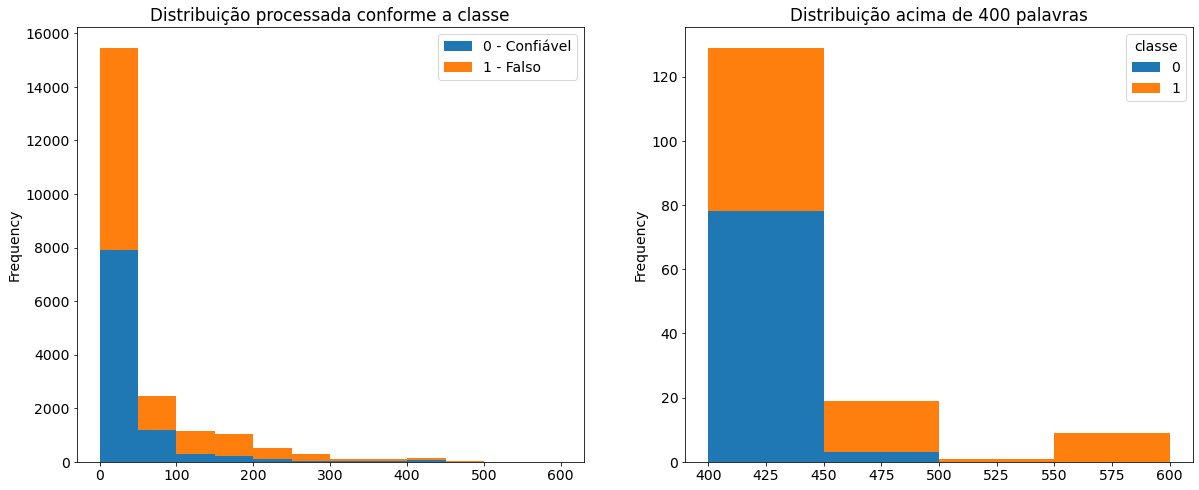

In [ ]:
dfplot = dados.pivot(columns='classe').qtde_texto_processado
dfplot.columns = ['0 - Confiável', '1 - Falso']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes1 = dfplot.plot(
    ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 601, 50)), 
    title="Distribuição processada conforme a classe")
evitar_bias = dados[dados['qtde_texto_processado'] > 400]
axes2 = evitar_bias.pivot(columns='classe').qtde_texto_processado.plot(
    ax=axes[1], kind='hist', stacked=True, bins=list(range(400, 601, 50)), 
    title="Distribuição acima de 400 palavras")

<AxesSubplot:title={'center':'Distribuição com menos de 100 palavras'}, ylabel='Frequency'>

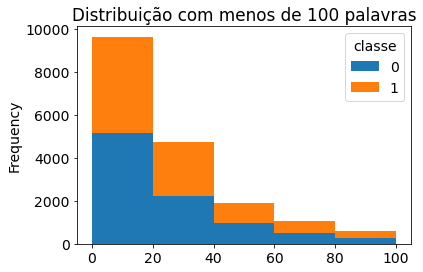

In [ ]:
poucas_palavras = dados[dados['qtde_texto_processado'] < 100]
poucas_palavras.pivot(columns='classe').qtde_texto_processado.plot(kind='hist', stacked=True, bins=list(range(0, 101, 20)), 
    title="Distribuição com menos de 100 palavras")

In [ ]:
display(f"Total de amostras: {dados.shape[0]}", f"Amostras com muitas palavras: {evitar_bias.shape[0]}")
display("0 = Confiável;  1 = Falso")
display(evitar_bias.groupby('classe').qtde_texto_processado.count())
display(poucas_palavras.groupby('classe').qtde_texto_processado.count())

'Total de amostras: 21289'

'Amostras com muitas palavras: 197'

'0 = Confiável;  1 = Falso'

classe
0    98
1    99
Name: qtde_texto_processado, dtype: int64

classe
0    9081
1    8855
Name: qtde_texto_processado, dtype: int64

'Amostras removidas: 10187'

classe
0    4488
1    6614
Name: qtde_texto_processado, dtype: int64

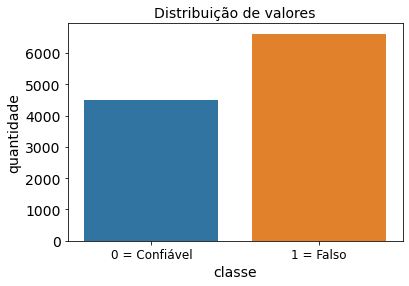

,texto
classe,
0,4488
1,6614


In [ ]:
# testes do ponto de corte para manter balanceamento
display(f"Amostras removidas: {dados[(dados['qtde_texto_processado'] <= 20) | (dados['qtde_texto_processado'] >= 400)].shape[0]}")
display(dados[(dados['qtde_texto_processado'] > 20) & (dados['qtde_texto_processado'] < 400)].groupby('classe').qtde_texto_processado.count())
dados_desbalanceados = dados[(dados['qtde_texto_processado'] > 20) & (dados['qtde_texto_processado'] < 400)]
exibir_distribuicao_valores(dados_desbalanceados)

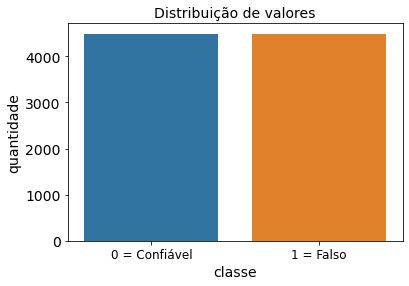

,texto
classe,
0,4488
1,4488


In [ ]:
# Encontrei um ponto de corte que manteve o balanceamento perfeito da base
rebalancear = dados_desbalanceados.groupby('classe')
dados_balanceados = pd.DataFrame(rebalancear.apply(lambda x: x.sample(rebalancear.size().min()).reset_index(drop=True)))
dados_balanceados.reset_index(inplace=True, drop=True)
exibir_distribuicao_valores(dados_balanceados)

### Pesquisando se alguma palavra se destaca demais e pode gerar viés

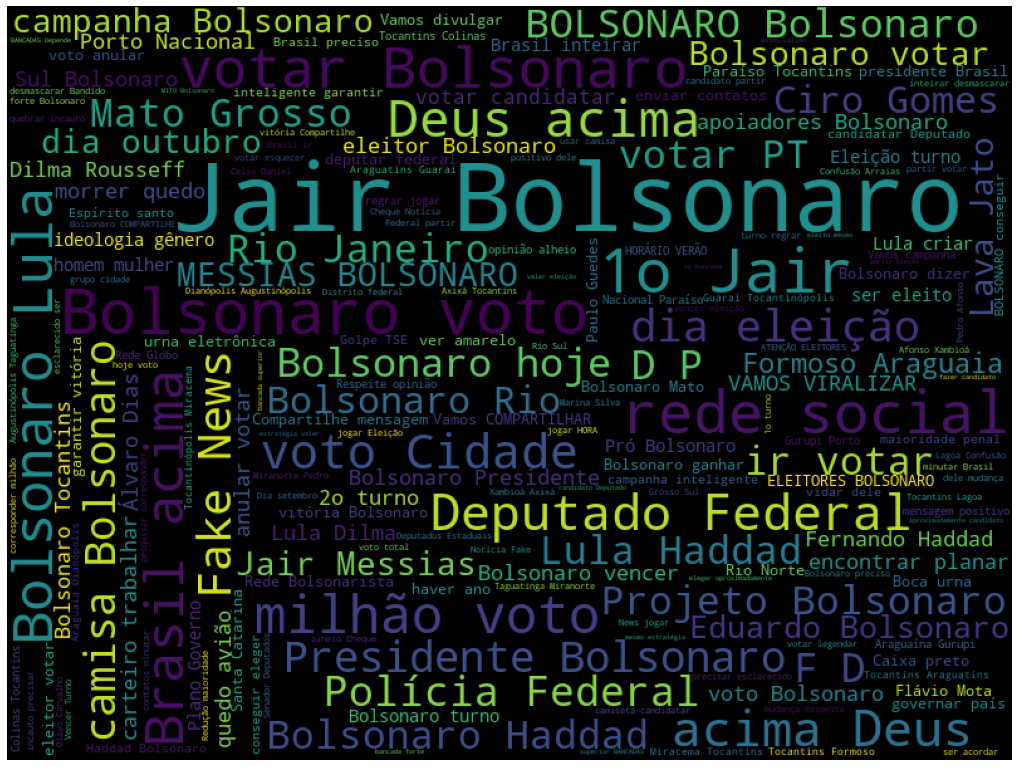

In [ ]:
# Avaliar as palavras mais usadas em todo dataset
wordcloud_full = WordCloud( background_color='black', width=800, height=600)
nuvem = wordcloud_full.generate(' '.join(dados_balanceados['texto_processado']))
plt.figure(figsize=(18,25))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

In [ ]:
# remove pontuação para gerar lista somente de palavras para as próximas análises
lista_confiavel = re.sub(' +', ' ', re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', ' '.join(dados_balanceados[dados_balanceados['classe']==0]['texto_processado'])))
lista_falsa = re.sub(' +', ' ', re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', ' '.join(dados_balanceados[dados_balanceados['classe']==1]['texto_processado'])))

In [ ]:
# Gera nuvem de palavras para cada grupo
wc_confiavel = WordCloud( background_color='black', width=800, height=600)
nuvem_confiavel = wc_confiavel.generate(lista_confiavel)
wc_falsa = WordCloud( background_color='black', width=800, height=600)
nuvem_falsa = wc_falsa.generate(lista_falsa)

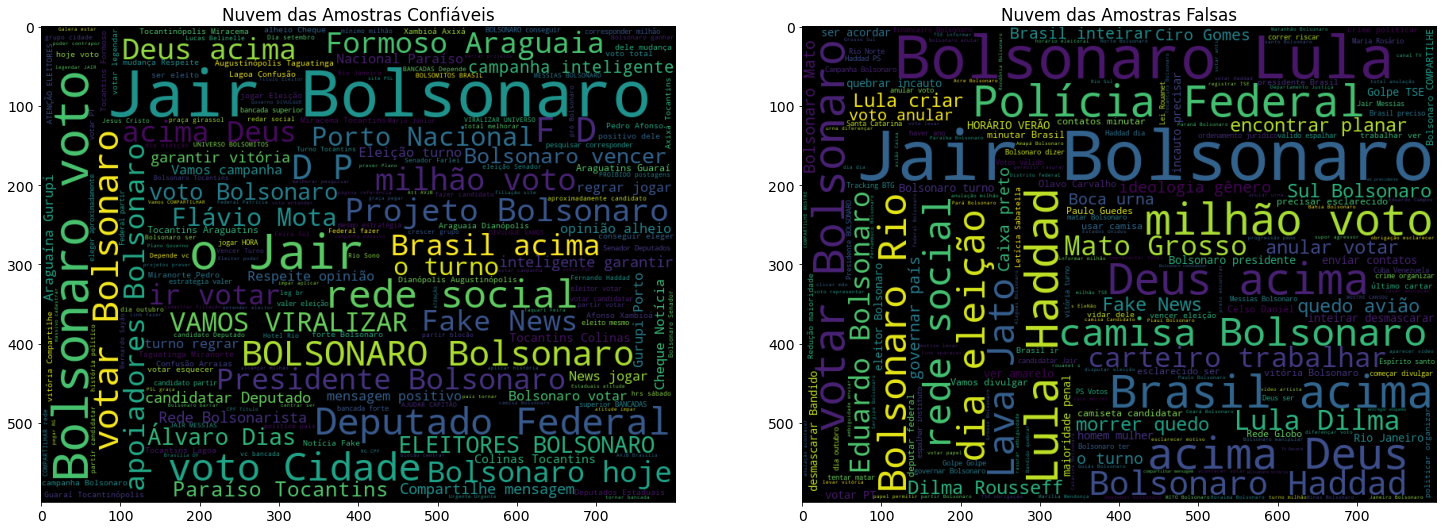

In [ ]:
# Plots núvens lado a lado para comparar
f, plots = plt.subplots(nrows=1, ncols=2, figsize=(25, 45))
plots[0].imshow(nuvem_confiavel)
plots[0].set_title('Nuvem das Amostras Confiáveis')
plots[1].imshow(nuvem_falsa)
plots[1].set_title('Nuvem das Amostras Falsas')
plt.show()

In [ ]:
import nltk
def avaliar_ngrams(corpus, title, n=2, top=20, plot_pos=None):
  serie_plot = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.9, ax=plot_pos, title=title, figsize=(24, 8))

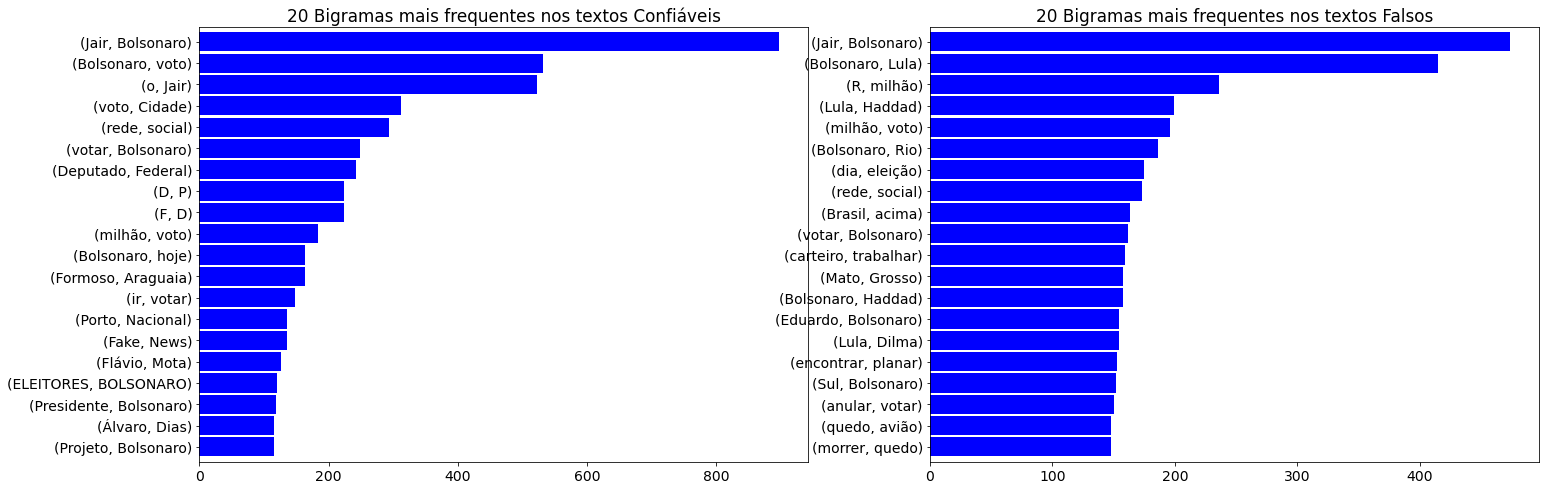

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
avaliar_ngrams(lista_confiavel, '20 Bigramas mais frequentes nos textos Confiáveis', plot_pos=axes[0])
avaliar_ngrams(lista_falsa, '20 Bigramas mais frequentes nos textos Falsos', plot_pos=axes[1])
#Penso em futuramente remover os primeiros ítems para evitar viés, e ou atualizar o corpus com notícias atuais, pois representa um ponto no tempo

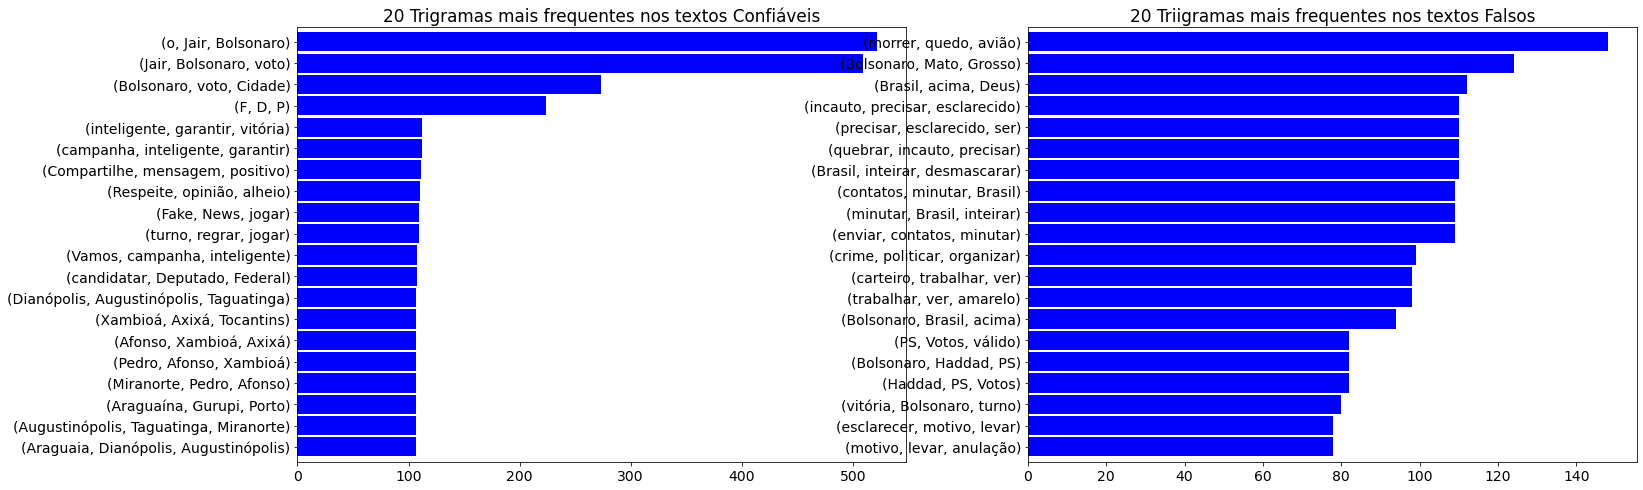

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
avaliar_ngrams(lista_confiavel, '20 Trigramas mais frequentes nos textos Confiáveis', n=3, plot_pos=axes[0])
avaliar_ngrams(lista_falsa, '20 Triigramas mais frequentes nos textos Falsos', n=3, plot_pos=axes[1])
#Com a visualização das trigramas dificulta fazer cortes, mas vejo que algumas trigramas se repetem em ordem diferente, 
# espero que o modelo BERT lide bem com isto, pois aqui estou usando o NLTK

In [ ]:
# Salva dados para uso no notebook do próximo passo.
os.makedirs("dados/", exist_ok=True)
dados.to_csv('dados/whatsappbr_corpus_processado.csv', sep = ',', index = True)